### The main content of this notebook is copied from 1.Artistic Neural Style Transfer copy.ipynb, and it is used to compare the impact of low-level detailed features and high-level global features on the results of style transfer.

### Import

In [1]:
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

### Build the Model

In [2]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

d:\ANAconda\envs\coding3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\ANAconda\envs\coding3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"

elif torch.backends.mps.is_available():
    device = "mps"

print(f'Using device: {device}')

Using device: cuda


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Loading the Images

In [5]:
def load_image(img_path, max_size=400, shape=None):

    image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [6]:
style = load_image("D:\Coding3\ExploringMachineIntelligence_Spring2024\Final\images\cyberpuck2.png").to(device)

content  = load_image("D:\Coding3\ExploringMachineIntelligence_Spring2024\Final\images\sculpture.png").to(device)

### Display the tensor as an image

In [7]:
def im_convert(tensor):    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

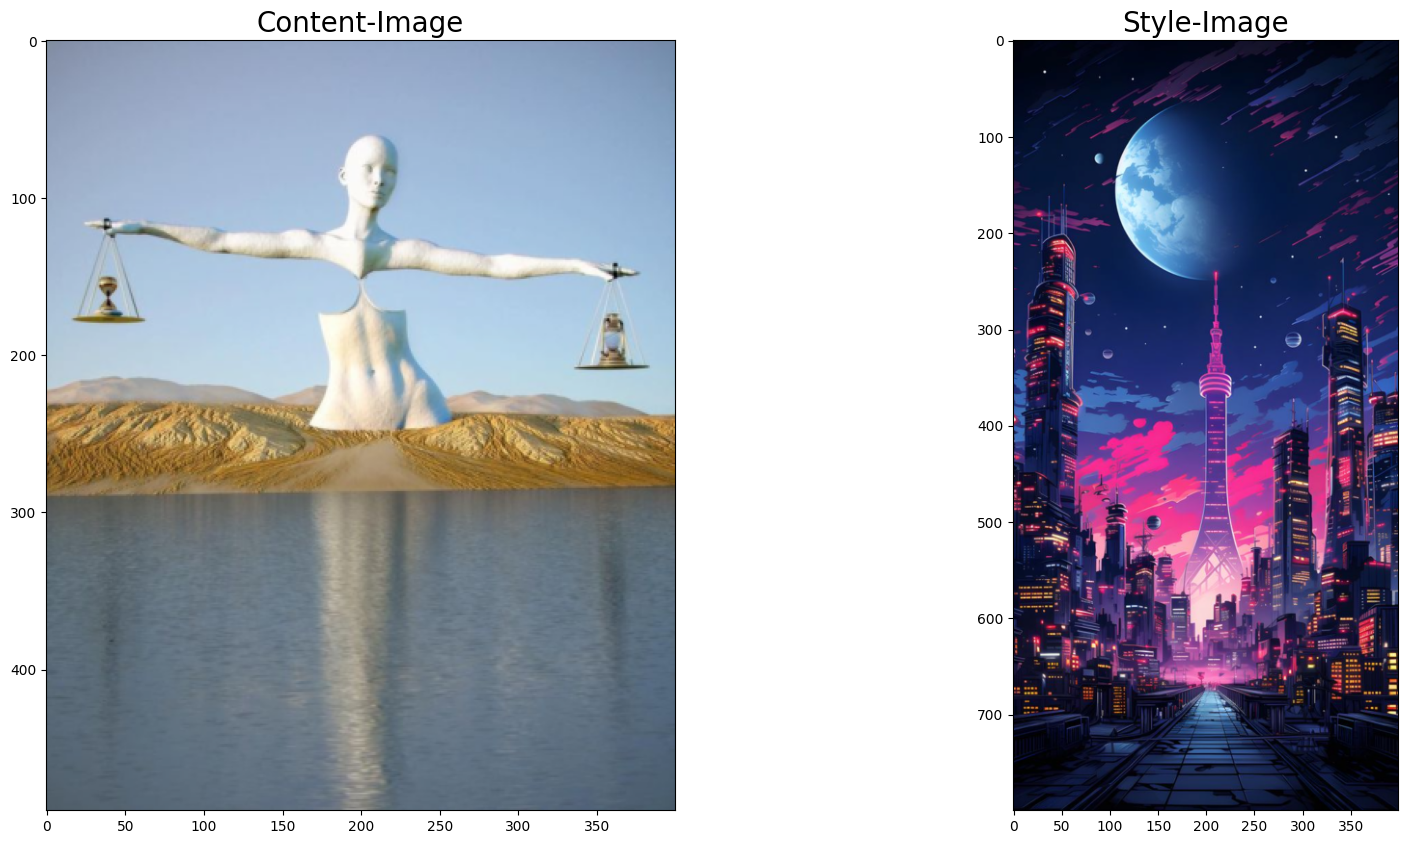

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.set_title("Content-Image",fontsize = 20)
ax2.imshow(im_convert(style))
ax2.set_title("Style-Image", fontsize = 20)
plt.show()

In [9]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Intermediate Layers for Style and Content

In [10]:
# Extract high-level global features
def get_features(image, model, layers=None):
    
    if layers is None:
        layers = { '20': 'conv4_1',
                   '22': 'conv4_2', 
                   '29': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

### Loss Functions

In [11]:
def gram_matrix(tensor):
    
    _, d, h, w = tensor.size()
    
    tensor = tensor.view(d, h * w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [12]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

### Assigning Weights

In [13]:
style_weights = {'conv4_1': 0.4,
                 'conv4_2': 0.2, 
                 'conv5_1': 0.4}

content_weight = 1e-2  
style_weight = 1e9

### Run the Model

Total loss:  1167929600.0


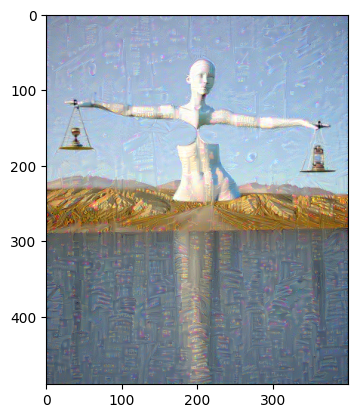

Total loss:  764495936.0


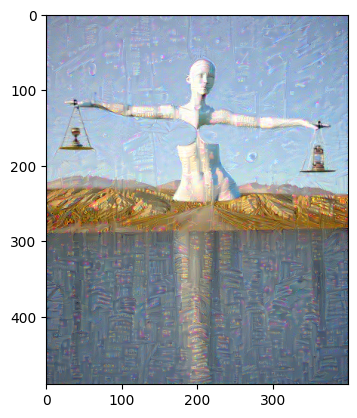

Total loss:  607986496.0


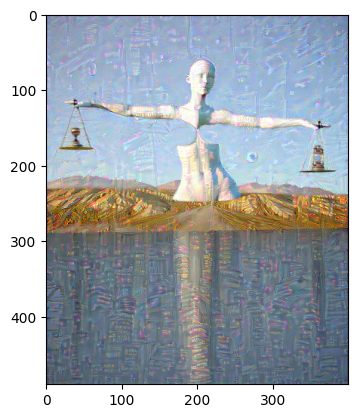

Total loss:  519563680.0


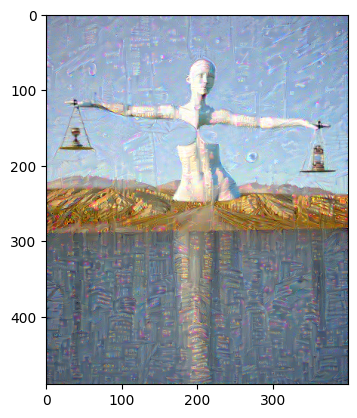

Total loss:  461450880.0


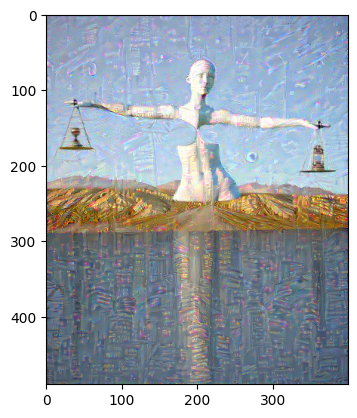

Total loss:  421149408.0


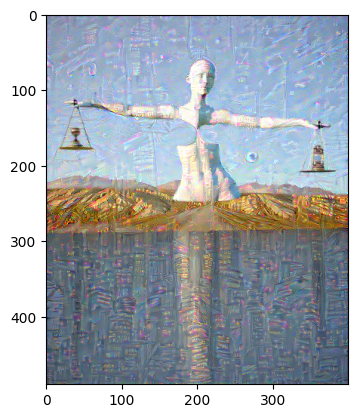

Total loss:  394198720.0


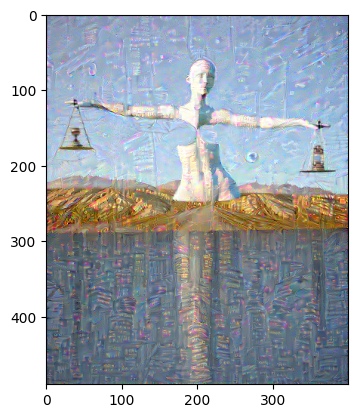

Total loss:  366749760.0


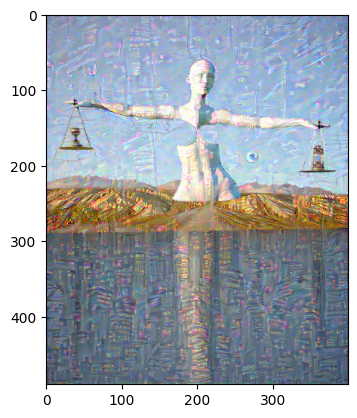

Total loss:  349066144.0


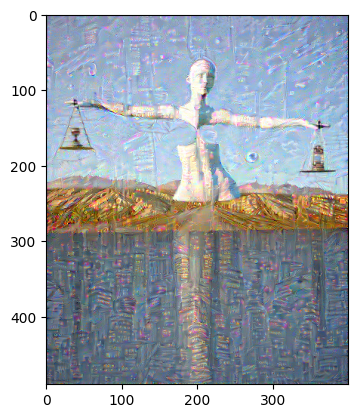

Total loss:  329338880.0


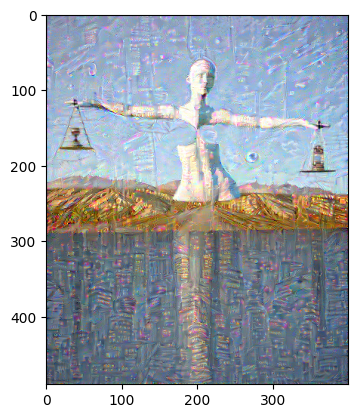

Total loss:  315522656.0


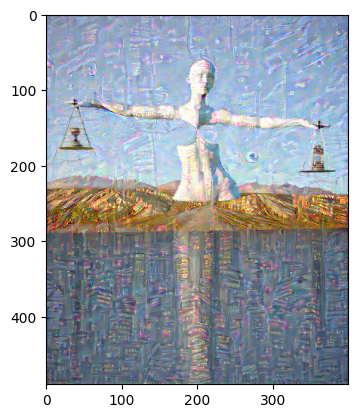

Total loss:  304556672.0


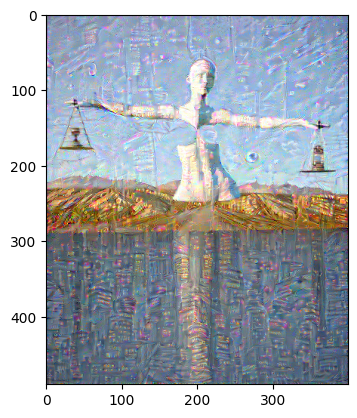

Total loss:  293089920.0


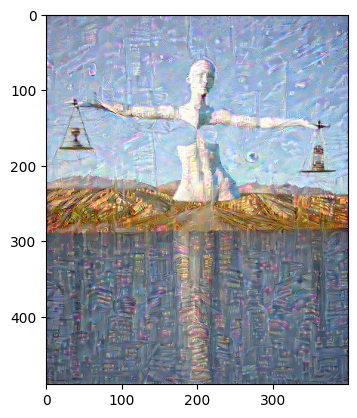

Total loss:  285827328.0


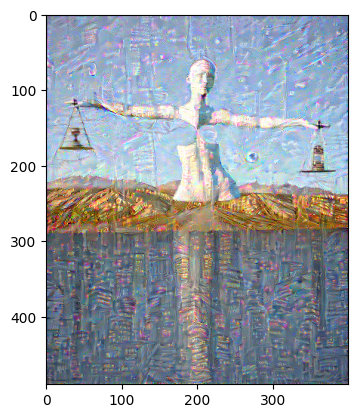

Total loss:  280734464.0


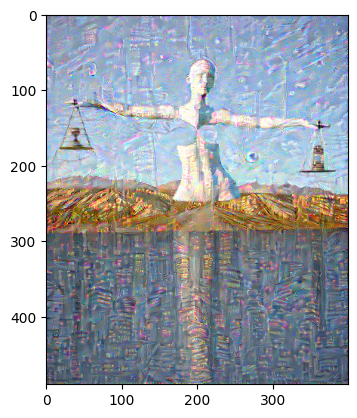

Total loss:  275110528.0


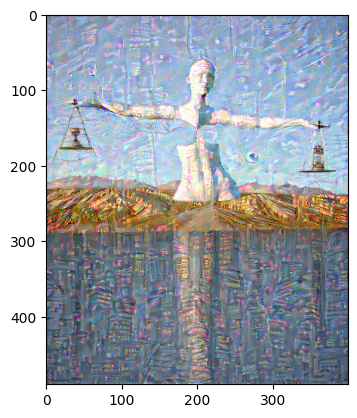

Total loss:  262518768.0


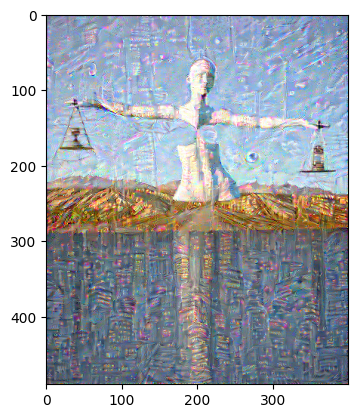

In [14]:
show = 400

optimizer = optim.Adam([target], lr=0.01)
steps = 7000  

for i in range(1, steps+1):
    
    target_features = get_features(target, vgg)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i % show == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()